# 0. ライブラリのインポート

In [3]:
import pandas as pd # collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np  # foundational package for scientific computing
import re           # Regular expression operations
import matplotlib.pyplot as plt # Collection of functions for scientific and publication-ready visualization
%matplotlib inline
import plotly.offline as py     # Open source library for composing, editing, and sharing interactive data visualization 
from matplotlib import pyplot
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter

# Machine learning libraries
import xgboost as xgb  # Implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning
import seaborn as sns  # Visualization library based on matplotlib, provides interface for drawing attractive statistical graphics

import sklearn         # Collection of machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# 1. データ簡易チェック

In [4]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [5]:
PassengerID = test.PassengerId

In [6]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [1400]:
train.info()
print('_'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

## ⇒ データが一部欠けている

# 2. データ分析

## 2.1 性別と生存率の関係

In [19]:
train.groupby("Sex")["Survived"].value_counts()

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

In [21]:
train.groupby("Sex")["Survived"].count()

Sex
female    314
male      577
Name: Survived, dtype: int64

[Text(0,0,'female'), Text(0,0,'male')]

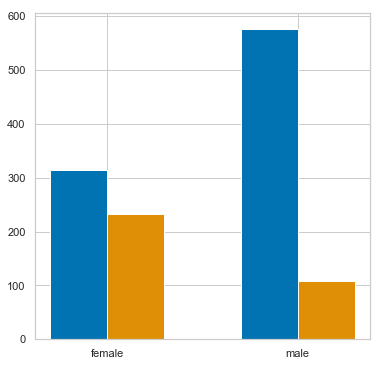

In [17]:
sns.set()
sns.set_style("whitegrid")
sns.set_palette("colorblind")
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
left = np.arange(2)
width=0.3
left2 = left+0.3
train.groupby("Sex")["Survived"].value_counts()
height = train.groupby("Sex")["Survived"].count()
height2 = train[train["Survived"]==1].groupby("Sex")["Survived"].count()
label=height.index
ax.bar(left,height,width=width)
ax.bar(left2,height2,width=width)
ax.set_xticks(left+width/2)
ax.set_xticklabels(label)

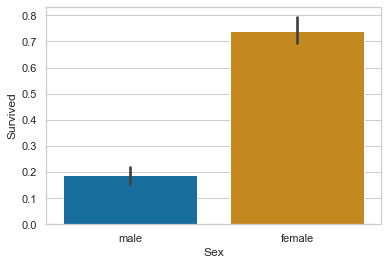

In [1402]:
sns.barplot(x="Sex", y="Survived",data=train);

In [1403]:
full_data=[test,train]
for dataset in full_data:
    dataset["Sex"]=dataset["Sex"].map({"female":0,"male":1}).astype(int)

## ⇒ 性別は重要な因子。モデルに入れよう。

## 2.2 料金と生存率の関係

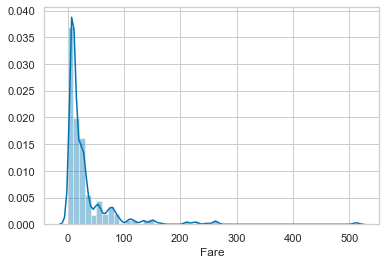

In [1404]:
sns.distplot(train["Fare"])

In [1405]:
for dataset in full_data:
    dataset["Fare"] = dataset["Fare"].apply(lambda x: np.log(x) if x>0 else 0)

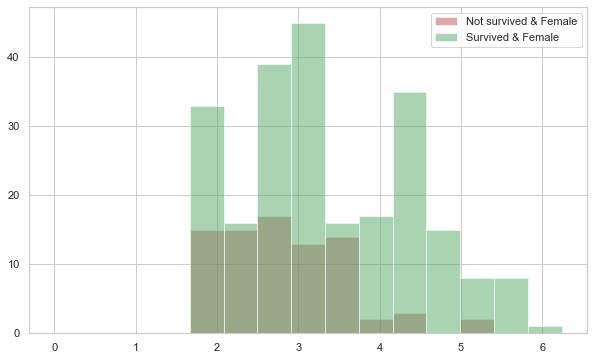

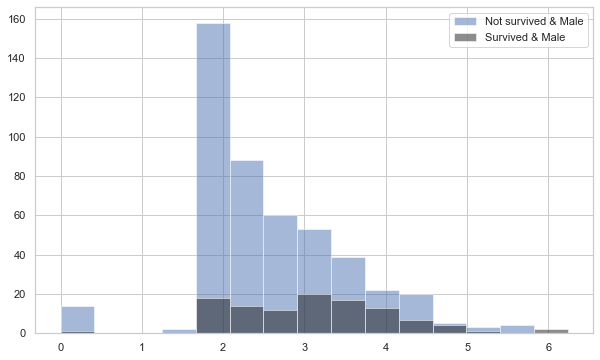

In [1406]:
sns.set()
sns.set_style("whitegrid")
sns.set_palette("Paired")



bin_num=15
_,bins= np.histogram(train["Fare"],bins=bin_num)

filter1 = (train["Survived"]==0) & (train["Sex"]==0)
filter2 = (train["Survived"]==0) & (train["Sex"]==1)
filter3 = (train["Survived"]==1) & (train["Sex"]==0)
filter4 = (train["Survived"]==1) & (train["Sex"]==1)


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.hist(train[filter1]["Fare"],bins=bins,alpha=0.5,color="r",label="Not survived & Female")
ax.hist(train[filter3]["Fare"],bins=bins,alpha=0.5,color="g",label="Survived & Female")
                 
ax.legend()
plt.show()
                 
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.hist(train[filter2]["Fare"],bins=bins,alpha=0.5,color="b",label="Not survived & Male")
ax.hist(train[filter4]["Fare"],bins=bins,alpha=0.5,color="k",label="Survived & Male")

ax.legend()
plt.show()


女性：　死亡者数とチケット料金には強い相関あり。生存者数とチケット料金には弱い相関あり。  
男性：死亡者とチケット料金には強い相関あり。生存者とチケット料金には相関なし。

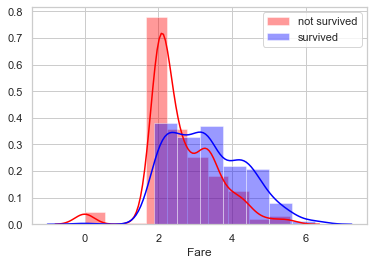

In [1407]:
sns.distplot(train["Fare"][train["Survived"]==0],bins=10,label="not survived",color="red")
sns.distplot(train["Fare"][train["Survived"]==1],bins=10,label="survived",color="blue")
plt.legend()

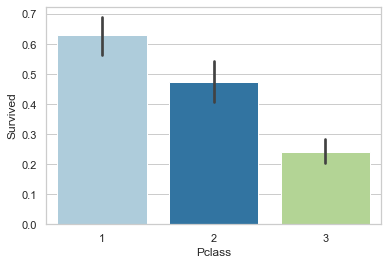

In [1408]:
sns.barplot(x="Pclass",y="Survived",data=train)

In [1409]:
train["Pclass"].isnull().sum()
test["Pclass"].isnull().sum()

0

## ⇒　客室等級は重要な因子。モデルに入れよう。

## 2.3 年齢と生存率の関係

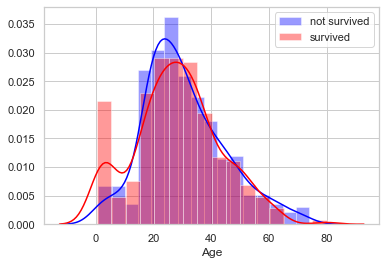

In [1410]:
sns.distplot(train[train["Age"].notnull()&(train["Survived"]==0)]["Age"],label="not survived",color="blue")
sns.distplot(train["Age"][train["Age"].notnull()&(train["Survived"]==1)],label="survived",color="red")
plt.legend()

In [1411]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
# Qcut is a quantile based discretization function to autimatically create categories (not used here)
# dataset['Age'] = pd.qcut(dataset['Age'], 6, labels=False)
# Using categories as defined above
    dataset.loc[ dataset['Age'] <= 14, 'Age'] 						          = 0
    dataset.loc[(dataset['Age'] > 14) & (dataset['Age'] <= 30), 'Age']        = 5
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 40), 'Age']        = 1
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 50), 'Age']        = 3
    dataset.loc[(dataset['Age'] > 50) & (dataset['Age'] <= 60), 'Age']        = 2
    dataset.loc[ dataset['Age'] > 60, 'Age'] 							      = 4
train['Age'].value_counts()

5    441
1    215
3     93
0     78
2     42
4     22
Name: Age, dtype: int64

## 2.3 Embarked

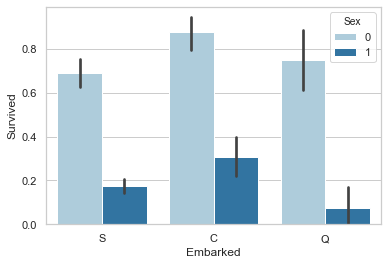

In [1412]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=train);

## ⇒ 年齢を6つに分けて因子として考慮する。
## ⇒ 性別、客室等級、年齢を分析し、整理完了。

## 2.4 兄弟

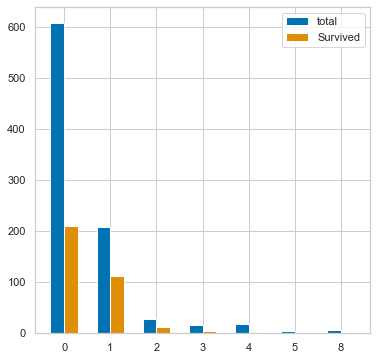

In [1413]:
height = train.groupby("SibSp")["Survived"].count()
height2 = height.copy()
height2[:] = 0
tmp = train[train["Survived"]==1].groupby("SibSp")["Survived"].count()
height2.iloc[tmp.index.values] = tmp.values

sns.set()
sns.set_style("whitegrid")
sns.set_palette("colorblind")
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
left = np.arange(height.shape[0])
width=0.3
left2 = left+0.3
label=height.index
ax.bar(left,height,width=width,label="total")
ax.bar(left2,height2,width=width,label="Survived")
ax.set_xticks(left+width/2)
ax.set_xticklabels(label)

ax.legend()
plt.show()

兄弟の数と死亡確率に相関がある。  
0,1に有意差あり、かつデータ数十分であるため、0,1,それ以上の３つの状態に分ける。

In [1414]:
full_data=[test,train]
for dataset in full_data:
    dataset["SibSp"][dataset["SibSp"]==0] = 0
    dataset["SibSp"][dataset["SibSp"]==1] = 1
    dataset["SibSp"][dataset["SibSp"]>=2] = 2

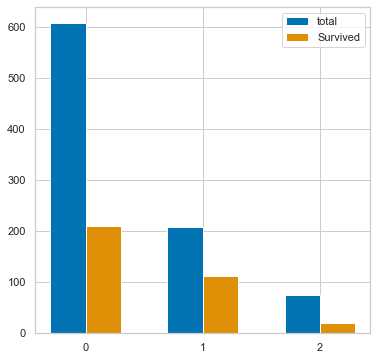

In [1415]:
height = train.groupby("SibSp")["Survived"].count()
height2 = height.copy()
height2[:] = 0
tmp = train[train["Survived"]==1].groupby("SibSp")["Survived"].count()
height2.iloc[tmp.index.values] = tmp.values

sns.set()
sns.set_style("whitegrid")
sns.set_palette("colorblind")
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
left = np.arange(height.shape[0])
width=0.3
left2 = left+0.3
label=height.index
ax.bar(left,height,width=width,label="total")
ax.bar(left2,height2,width=width,label="Survived")
ax.set_xticks(left+width/2)
ax.set_xticklabels(label)

ax.legend()
plt.show()

In [1416]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

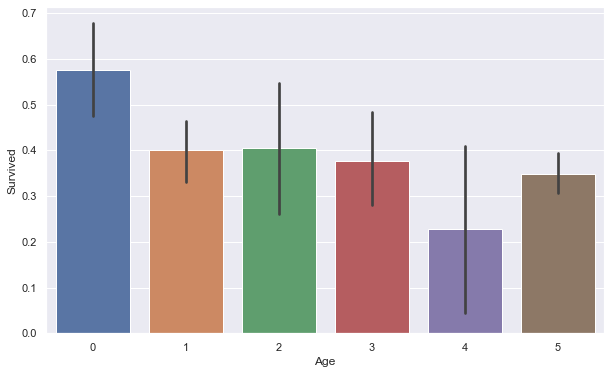

In [1417]:
sns.set()
f = plt.figure(figsize=(10,6))
f.add_subplot(1,1,1)
# sns.barplot(x="Age", y="Survived",data=train, hue="SibSp")
sns.barplot(x="Age", y="Survived",data=train)

## 2.5親子関係

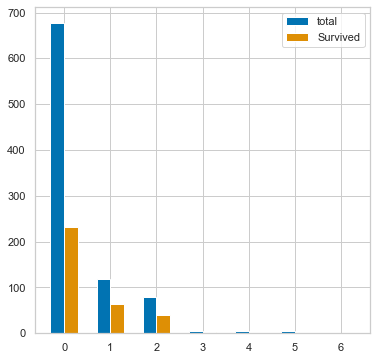

In [1418]:
height = train.groupby("Parch")["Survived"].count()
height2 = height.copy()
height2[:] = 0
tmp = train[train["Survived"]==1].groupby("Parch")["Survived"].count()
height2.iloc[tmp.index.values] = tmp.values

sns.set()
sns.set_style("whitegrid")
sns.set_palette("colorblind")
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
left = np.arange(height.shape[0])
width=0.3
left2 = left+0.3
label=height.index
ax.bar(left,height,width=width,label="total")
ax.bar(left2,height2,width=width,label="Survived")
ax.set_xticks(left+width/2)
ax.set_xticklabels(label)

ax.legend()
plt.show()

In [1419]:
full_data=[test,train]
for dataset in full_data:
    dataset["Parch"][dataset["Parch"]==0] = 0
    dataset["Parch"][dataset["Parch"]==1] = 1
    dataset["Parch"][dataset["Parch"]>=2] = 2

親子の数と生存率に相関あり。

## 2.7 Pclass

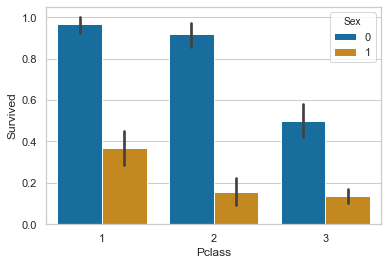

In [1420]:
sns.barplot(x="Pclass",y="Survived",hue="Sex",data=train)

In [1421]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

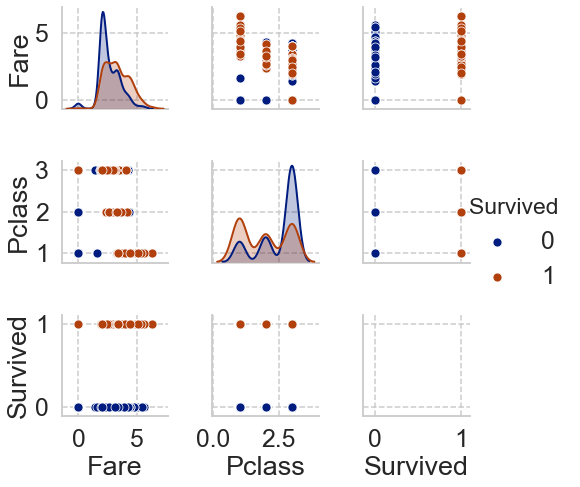

In [1422]:
sns.set()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_context("paper", 1.5, {"lines.linewidth": 4})
sns.set_palette("winter_r", 8, 1)
sns.set('talk', 'whitegrid', 'dark', font_scale=1.5,
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
sns.pairplot(train[["Fare","Pclass",'Survived']],hue='Survived')

なんか、無料で一等席に乗っている人がいるね。  
料金よりも等席のほうがよい指標かもしれない。

## 2.8 キャビン

In [1423]:
train["Cabin"] = train["Cabin"].fillna("floor")
filter=train["Cabin"]!="floor"
train.loc[filter,"Cabin"]="room"

In [1424]:
train[["Cabin","Pclass"]]
train.groupby(["Pclass","Cabin"])["Survived"].value_counts()
# train["Cabin"].isnull()
# train["Cabin"]

Pclass  Cabin  Survived
1       floor  0            21
               1            19
        room   1           117
               0            59
2       floor  0            94
               1            74
        room   1            13
               0             3
3       floor  0           366
               1           113
        room   0             6
               1             6
Name: Survived, dtype: int64

In [1425]:
test["Cabin"] = test["Cabin"].fillna("floor")
filter=test["Cabin"]!="floor"
test.loc[filter,"Cabin"]="room"
full_data=[test,train]
for dataset in full_data:
    dataset["Cabin"]=dataset["Cabin"].map({"floor":0,"room":1}).astype(int)

部屋か雑魚寝かが生存率と相関あり。

In [1426]:
def convertName(df):
    df["Name2"]=df["Name"]
    df["Name2"]="other"
#     sub_list = ["Mr","Mrs","Miss","Master","Dr","Rev","Ms","Col","Major"]
    sub_list=["Mr","Mrs","Miss","Master","Rev","Col"]
    for sub in sub_list:
        filter = df["Name"].map(lambda x : sub in x)
        df.loc[filter,"Name2"] = sub
        filter = df["Name"].map(lambda x : sub in x)
        df.loc[filter,"Name2"] = sub
        filter = df["Name"].map(lambda x : sub in x)
        df.loc[filter,"Name2"] = sub
        filter = df["Name"].map(lambda x : sub in x)
        df.loc[filter,"Name2"] = sub
        filter = df["Name"].map(lambda x : sub in x)
        df.loc[filter,"Name2"] = sub
        filter = df["Name"].map(lambda x : sub in x)
        df.loc[filter,"Name2"] = sub
        filter = df["Name"].map(lambda x : sub in x)
        df.loc[filter,"Name2"] = sub
        filter = df["Name"].map(lambda x : sub in x)
        df.loc[filter,"Name2"] = sub
        filter = df["Name"].map(lambda x : sub in x)
        df.loc[filter,"Name2"] = sub
        filter = df["Name"].map(lambda x : sub in x)
        df.loc[filter,"Name2"] = sub
        
    return df

full_data=[test,train]
for dataset in full_data:
    dataset = convertName(dataset)

In [1427]:
train.groupby("Name2")["Survived"].value_counts()

Name2   Survived
Col     0             7
        1             3
Master  1            23
        0            17
Miss    1           126
        0            55
Mr      0           430
        1            82
Mrs     1           100
        0            26
Rev     0             6
other   0             8
        1             8
Name: Survived, dtype: int64

In [1428]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name2
0,892,3,"Kelly, Mr. James",1,1,0,0,330911,2.057860,0,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,3,1,0,363272,1.945910,0,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",1,4,0,0,240276,2.270836,0,Q,Mr
3,895,3,"Wirz, Mr. Albert",1,5,0,0,315154,2.159003,0,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,5,1,1,3101298,2.508582,0,S,Mrs
5,897,3,"Svensson, Mr. Johan Cervin",1,0,0,0,7538,2.221917,0,S,Mr
6,898,3,"Connolly, Miss. Kate",0,5,0,0,330972,2.031983,0,Q,Miss
7,899,2,"Caldwell, Mr. Albert Francis",1,5,1,1,248738,3.367296,0,S,Mr
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",0,5,0,0,2657,1.978128,0,C,Mrs
9,901,3,"Davies, Mr. John Samuel",1,5,2,0,A/4 48871,3.184284,0,S,Mr


## Family

In [1429]:
# def createFamily(df):
#     df["Family"] = df["SibSp"]+df["Parch"]
#     df["IsFamily"] = 1
#     df["IsFamily"].loc[df["Family"]==0] = 0
#     return df

# train = createFamily(train)
# test = createFamily(test)

# 3. 訓練データの作成

## 3.1 余計な因子を削除

In [1430]:
# Feature selection
# drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Cabin','Fare', 'Embarked']
drop_elements = ['PassengerId', 'Ticket',"Fare","Name"]


train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [1431]:
# Hot Encoder to Name
def hot_encoder1(df):
    df_dummy = pd.get_dummies(df['Name2'])
    df = pd.concat([df.drop(['Name2'],axis=1),df_dummy],axis=1)
    return df

train = hot_encoder1(train)
test = hot_encoder1(test)

In [1432]:
# Hot Encoder to Embarked
def hot_encoder2(df):
    df_dummy = pd.get_dummies(df["Embarked"])
    df = pd.concat([df.drop(["Embarked"],axis=1),df_dummy],axis=1)
    return df

train = hot_encoder2(train)
test = hot_encoder2(test)

In [1433]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Col,Master,Miss,Mr,Mrs,Rev,other,C,Q,S
0,0,3,1,5,1,0,0,0,0,0,1,0,0,0,0,0,1
1,1,1,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0
2,1,3,0,5,0,0,0,0,0,1,0,0,0,0,0,0,1
3,1,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1
4,0,3,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1
5,0,3,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0
6,0,1,1,2,0,0,1,0,0,0,1,0,0,0,0,0,1
7,0,3,1,0,2,1,0,0,1,0,0,0,0,0,0,0,1
8,1,3,0,5,0,2,0,0,0,0,0,1,0,0,0,0,1
9,1,2,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0


## 3.2 データ整形

In [1434]:
# X_train (all features for training purpose but excluding Survived),
# Y_train (survival result of X-Train) and test are our 3 main datasets for the next sections
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]

X_test = test.copy()
#std_scaler = StandardScaler()
#X_train = std_scaler.fit_transform(X_train)
#X_test = std_scaler.transform(X_test)

# 4. モデル作成

## 4.1 Logistic Regression

In [1435]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
#Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

82.38

## 4.2. Support Vector Machines (supervised)

In [1436]:
svc=SVC()
svc.fit(X_train, Y_train)
#Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

82.72

## 4.3. k-Nearest Neighbors algorithm (k-NN)

In [1437]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=10, p=2, 
                           weights='uniform')
knn.fit(X_train, Y_train)
knn_predictions = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

# Preparing data for Submission 1
test_Survived = pd.Series(knn_predictions, name="Survived")
Submission1 = pd.concat([PassengerID,test_Survived],axis=1)
acc_knn

83.28

## 4.4. Naive Bayes classifier

In [1438]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
#Y_pred = gaussian.predict(test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

54.55

## 4.5. Perceptron

In [1439]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
#Y_pred = perceptron.predict(test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

80.13

## 4.6. Linear SVC

In [1440]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
#Y_pred = linear_svc.predict(test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

82.83

## 4.7. Stochastic Gradient Descent (sgd)

In [1441]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
#Y_pred = sgd.predict(test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

77.89

## 4.8. Decision tree

In [1442]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
#Y_pred = decision_tree.predict(test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

88.1

## 4.9. Random Forests

In [1443]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
random_forest_predictions = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

88.1

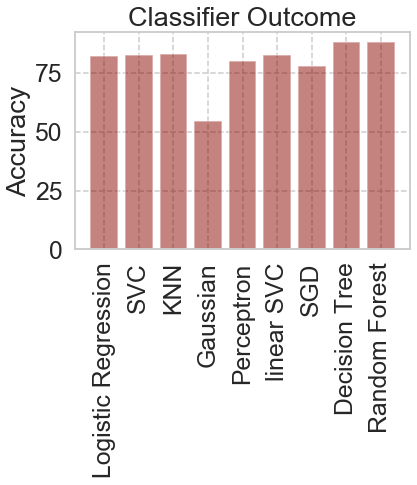

In [1444]:
objects = ('Logistic Regression', 'SVC', 'KNN', 'Gaussian', 'Perceptron', 'linear SVC', 'SGD', 'Decision Tree', 'Random Forest')
x_pos = np.arange(len(objects))
accuracies1 = [acc_log, acc_svc, acc_knn, acc_gaussian, acc_perceptron, acc_linear_svc, acc_sgd, acc_decision_tree, acc_random_forest]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='r')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Accuracy')
plt.title('Classifier Outcome')
plt.show()

## 4.10Cross Validation
##         （未知のデータに対するモデルの性能を評価）

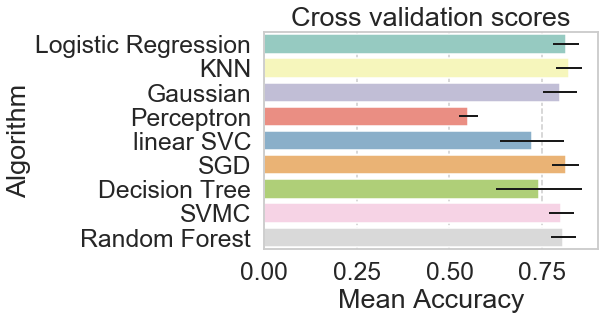

In [1445]:
# Cross validate model with Kfold stratified cross validation
from sklearn.model_selection import StratifiedKFold

#テストデータを10個に分ける
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 2

classifiers = []
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(GaussianNB())
classifiers.append(Perceptron(random_state=random_state))
classifiers.append(LinearSVC(random_state=random_state))
classifiers.append(SGDClassifier(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(RandomForestClassifier(random_state = random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":['Logistic Regression',  'KNN', 'Gaussian',
    'Perceptron', 'linear SVC', 'SGD', 'Decision Tree','SVMC', 'Random Forest']})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

##  ⇒　ランダムフォレストを使おう！

## 4.11 GridSearchCV
##  （ランダムフォレストのハイパーパラメータをチューニング）

In [1446]:
# Random Forest
rf_param_grid = {"max_depth": [None],
#               "max_features": [1, 3, 7],
#               "min_samples_split": [2, 3, 7],
              "min_samples_leaf": [1, 3, 7],
              "bootstrap": [False],
              "n_estimators" :[300,600],
              "criterion": ["gini"]}
gsrandom_forest = GridSearchCV(random_forest,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsrandom_forest.fit(X_train,Y_train)
# Best score
random_forest_best = gsrandom_forest.best_estimator_
gsrandom_forest.best_score_

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    5.8s finished


0.8204264870931538

In [1495]:
# Xgboost
kfold = StratifiedKFold(n_splits=20)
gbm = xgb.XGBClassifier(random_state=1)
cv_params = {'max_depth': [1], 
             'min_child_weight': [5],
             'learning_rate': [0.5], 'n_estimators':[50], 'seed':[0], 'subsample': [0.8], 'colsample_bytree': [0.9], 
             'objective': ['binary:logistic']
            }
optimized_GBM = GridSearchCV(gbm,param_grid = cv_params, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
optimized_GBM.fit(X_train,Y_train)
# Best score
optimized_GBM_best = optimized_GBM.best_estimator_
print(f"best score: {optimized_GBM.best_score_}")
print(f"best params: {optimized_GBM.best_params_}")

Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


best score: 0.8249158249158249
best params: {'colsample_bytree': 0.9, 'learning_rate': 0.5, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'binary:logistic', 'seed': 0, 'subsample': 0.8}


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.3s finished


In [ ]:
0.8226711560044894

2019年  ５月結果: 0.7968574635241302  
2019年11月28日結果: 0.8271604938271605  
2019年11月28日結果: 0.8316498316498316  
2019年11月28日結果: 0.8226711560044894  
2019年11月30日結果: 0.8305274971941639

In [1350]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Cabin,Col,Master,Miss,Mr,Mrs,Rev,other,C,Q,S
0,3,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,3,0,3,1,0,0,0,0,0,0,1,0,0,0,0,1
2,2,1,4,0,0,0,0,0,0,1,0,0,0,0,1,0
3,3,1,5,0,0,0,0,0,0,1,0,0,0,0,0,1
4,3,0,5,1,1,0,0,0,0,0,1,0,0,0,0,1


In [1347]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Col,Master,Miss,Mr,Mrs,Rev,other,C,Q,S
0,0,3,1,5,1,0,0,0,0,0,1,0,0,0,0,0,1
1,1,1,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0
2,1,3,0,5,0,0,0,0,0,1,0,0,0,0,0,0,1
3,1,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1
4,0,3,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1


# 5. 提出ファイルの作成

In [1348]:
test_predict=random_forest_best.predict(test)
submission = pd.concat([PassengerID,pd.DataFrame({"Survived":test_predict})],axis=1)
submission.to_csv("predict_result.csv",index=False)

In [1496]:
## Xgboost
test_predict=optimized_GBM_best.predict(test)
submission = pd.concat([PassengerID,pd.DataFrame({"Survived":test_predict})],axis=1)
submission.to_csv("predict_result.csv",index=False)